<a href="https://colab.research.google.com/github/GP-FCI-SU/Breast-Cancer-Detection-with-Convolutional-Neural-Networks/blob/master/model_5_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
local_zip = '/content/drive/My Drive/ddsm-mammography.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/ddsm')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
%matplotlib inline
tf.__version__

'2.2.0'

In [ ]:
features={#needed features to feed into our model  
            
            'label_normal': tf.io.FixedLenFeature([], tf.int64),
            'image': tf.io.FixedLenFeature([], tf.string)
        }#we have also the label feature but not used here

#make a function that will applied to the map transformation
def _parse_image_function(example_proto):
  parsed=tf.io.parse_single_example(example_proto,features)
  image = tf.io.decode_raw(parsed["image"], tf.uint8)
  image = tf.cast(image, tf.float32)/255.0
  image = tf.reshape(image, shape=[299,299,1])#our image shape and model expected one
  #image = tf.divide(iamge, 255.0)
  image = tf.repeat(image, repeats = 3, axis = -1)
  label = tf.cast(parsed["label_normal"], tf.int32) 
  return image,label #atuple of two tensos

In [ ]:
def get_dataset(filenames):
  dataset = tf.data.Dataset.list_files(filenames)
  dataset = dataset.interleave(tf.data.TFRecordDataset,  num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  #dataset = dataset.cache() # This dataset fits in RAM
  #dataset = dataset.repeat()
  #dataset = dataset.shuffle(2048)
  dataset = dataset.batch(batch_size=16) # drop_remainder will be needed on TPU
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
def load_val():
   X_cv = np.memmap( "/tmp/ddsm/test10_data/test10_data.npy")
   labels = tf.cast(np.load( "/tmp/ddsm/test10_labels.npy"),tf.int8)
   y_cv = np.zeros(len(labels))
   y_cv[labels != 0] = 1
   # X_cv = (X_cv - 127.0) / 255.0
  # X_cv = X_cv / 255.0
   X_cv= tf.cast(X_cv, tf.float32)/255.0
   X_cv = np.repeat(X_cv, repeats = 3, axis = -1)
   return X_cv, y_cv


In [ ]:
def get_training_dataset():
  return get_dataset(["/tmp/ddsm/training10_0/training10_0.tfrecords",
                     "/tmp/ddsm/training10_1/training10_1.tfrecords",
                     "/tmp/ddsm/training10_2/training10_2.tfrecords",
                     "/tmp/ddsm/training10_3/training10_3.tfrecords",
                     "/tmp/ddsm/training10_4/training10_4.tfrecords"]
                     )
def get_test_dataset():
  test_dataset = tf.data.Dataset.from_tensor_slices(load_val())
  test_dataset= test_dataset.batch(batch_size=16)
  test_dataset=test_dataset.cache()
  return test_dataset

#test_dataset=get_test_dataset()
#def get_validation_dataset():
 # return test_dataset

get_training_dataset()

<PrefetchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if epoch>8:
        self.model.save("/tmp/model_5_a_e{},{:.2f},{:.2f},{:.2f},{:.2f}.h5".format(epoch,logs['acc'],logs['loss'],logs['val_acc'],logs['val_loss']))

In [ ]:
class_weight = {1: 0.75,
                 0: 0.25}

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(299,299,3),
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False
base_model.summary()

In [ ]:
for image_batch, label_batch in get_training_dataset().take(1):
   pass

image_batch.shape

TensorShape([16, 299, 299, 3])

In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 10, 10, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)


In [ ]:

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])



In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callback=myCallback()
history = model.fit(
    get_training_dataset(),
      epochs=10,
      verbose= 1,
       callbacks=[callback],
      class_weight=class_weight)

Epoch 1/10
3493/3493 [==============================] - 267s 76ms/step - loss: 0.0991 - accuracy: 0.9075
Epoch 2/10
3493/3493 [==============================] - 267s 76ms/step - loss: 0.0949 - accuracy: 0.9103
Epoch 3/10
3493/3493 [==============================] - 267s 76ms/step - loss: 0.0926 - accuracy: 0.9131
Epoch 4/10
3493/3493 [==============================] - 267s 76ms/step - loss: 0.0908 - accuracy: 0.9141
Epoch 5/10
3493/3493 [==============================] - 270s 77ms/step - loss: 0.0898 - accuracy: 0.9152
Epoch 6/10
3493/3493 [==============================] - 269s 77ms/step - loss: 0.0893 - accuracy: 0.9160
Epoch 7/10
3493/3493 [==============================] - 268s 77ms/step - loss: 0.0885 - accuracy: 0.9166
Epoch 8/10
3493/3493 [==============================] - 267s 76ms/step - loss: 0.0883 - accuracy: 0.9168
Epoch 9/10
3493/3493 [==============================] - 266s 76ms/step - loss: 0.0881 - accuracy: 0.9172
Epoch 10/10
3493/3493 [==============================] 

KeyError: ignored

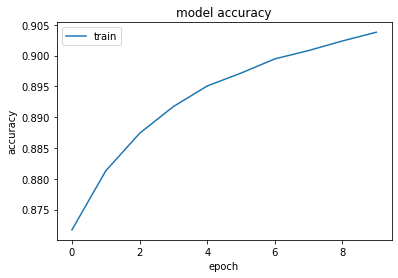

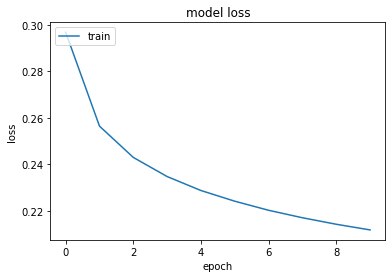

In [ ]:
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
model.save(filepath='/content/drive/My Drive/models/model_5_a.h5')